In [15]:
%logstop
%logstart -rtq ~/.logs/ML_Anomaly_Detection.py append
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Anomaly Detection
<!-- requirement: images/ocsvm.png -->
<!-- requirement: data/energy_data.csv -->

Often times, we need to find abnormal and unusual values in our data set. This process is referred to as **anomaly detection**. Identifying these data points can serve multiple purposes, such as

1. Removing outliers in a training set before fitting a machine learning model.
1. Analyzing a set of observations to identify whether something is wrong with the process. For example, are there any anomalous server logs that _may_ indicate a security breach.

The application of distinguishing whether something is abnormal or not falls into two divisions, **outlier** or **novelty detection**. These two terms are often lumped together but do have distinct definitions.

* **Outlier Detection:** The process of identifying observations that deviate substantially from the rest. Outlier detection models are trained with data sets that include outliers; it is not "clean". The model learns how much a point can deviate to be classified as an outlier.

* **Novelty Detection:** The process of identifying novel points by training a model with a data set that is not "polluted" with outliers. The model learns a boundary, or boundaries, the encompasses all normal/regular points. Any points that reside outside of these boundaries are new and thus novel.

The distinction is subtle but certain algorithms are referred to as either outlier or novelty detection. However, in practice, both classes can work well regardless if the application is purely novelty or outlier detection. A further discussion of novelty versus outlier detection can be read [here](https://scikit-learn.org/stable/modules/outlier_detection.html). Anomaly detection is _usually_ an unsupervised machine learning technique because rarely do we have labels for the observations. As such, the algorithms for detecting anomalies will rely purely on features of the observations.

In this notebook, we will go over two popular algorithms for outlier and novelty detection before working on a case study using time series data.

## Implementation in `scikit-learn`

In `scikit-learn`, anomaly detection algorithms are unsupervised learners. We will discuss two models for anomaly detection in `scikit-learn`, **one-class SVM** and **isolation forest**. Both are unsupervised learning models with a similar interface; the two key methods are:

* `fit(X)`: fit/train the model with data set `X`.
* `predict(X)`: determine whether the observations in `X` are inliers `1` or outliers `-1`.
* `decision_function(X)`: score/metric used to determine whether a point is an inlier/outlier.

Note, the interpretation of the output of the `decision_function` method is algorithm specific.

## One-class Support Vector Machines

The support vector machine classifier can be tweaked to serve novelty detection applications, referred to as one-class support vector machines. Consider a binary classification situation where all points in the training set belong to the same class, hence the name of the algorithm. Because all training points are in the same class, it is assumed that there are no outliers. The one-class SVM is a novelty detector. 

The points are transformed to a higher dimensional space where you have the freedom to locate the origin of the coordinates. The algorithm's task becomes to locate a hyperplane in the space that best separates the data from the origin. The catch is that hyperplane must go through the origin and located on the origin is the only member of the second class. The algorithm works by pushing as many of the vectors in the training set away from the origin in the feature space. As before, the model includes slack variable for vectors that violate the margin. The algorithm is prevented from pushing the vectors infinitely far away from the origin as the single member of the second class always resides on the hyperplane, incurring a large penalty when the origin is very far away from most of the training points. The algorithm has to find the best balance between origin separation and margin violations from the training set. The image below illustrates an example of the algorithm. For visual purposes, we have only used two dimensions but in practice the algorithm works in a large dimensional space to achieve better separation.

<img src="images/ocsvm.png" width="400">

The governing equation and constraints are

$$
\min_{\beta, \zeta, \rho} \frac{1}{2} \|\beta\|^2 + \frac{1}{\nu n}\sum_{j=1}^n \zeta_j - \rho \\
\mbox{subject to } \left\{ \begin{array} {cl} 
 h(x_{j\cdot}) \cdot \beta \ge \rho -\zeta_j &  \\
 \zeta_j \ge 0 ,
\end{array}\right.
$$

where $h(x_j)$ is a kernel function, $\rho$ is distance from the origin to the hyperplane, and $\nu$ is a hyperparameter that is the upper bound for the fraction of training error and the lower bound for the fraction of support vectors. Notice how the constraint is forcing points to be at least $\rho$ away from the margin, lest it incurs a margin violation as $\zeta$ must be set large enough to satisfy the inequality.

Let's use the one-class SVM to see how it works. We will be using the wine data set provided by `scikit-learn`. The details of the data set are not important, only that it has 178 observations with 13 numerical features.

**Question**
* What technique should we use on the wine data set to easily visualize our analysis?

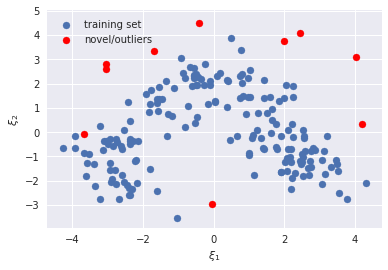

In [3]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# load data set
data = load_wine()
X = data['data']

# truncate to two variables
pipe = Pipeline([('scaler', StandardScaler()), ('dim_red', PCA(n_components=2))])
Xt = pipe.fit_transform(X)

# generate novel/outlier points
np.random.seed(1)
theta = 2*np.pi*np.random.random(10)
X_test = np.vstack((4*np.cos(theta) + np.random.random(10), 4*np.sin(theta) + np.random.random(10)))

plt.scatter(*Xt.T)
plt.scatter(*X_test, c='red')
plt.xlabel('$\\xi_1$')
plt.ylabel('$\\xi_2$');
plt.legend(["training set", "novel/outliers"]);

The visualization below plots the data along with the boundaries that determine whether a point is consider novel or not. The filled contour lines in the plot represent values of the decision function of the one-class SVM. The `decision_function` method reports the signed distance (negative means on the wrong side) between the point and the hyperplane. The visualization allows you to modify $\nu$, the upper bound for the false positive rate. You can also consider $\nu$ as the probability of having a new but regular observation outside the region defining regular points. As $\nu$ decreases, the area encompassing the regular points increases. As with the standard kernelized SVM, you can change the kernel function, but `rbf` usually works the best.

In [4]:
from sklearn.svm import OneClassSVM
from ipywidgets import interact, FloatSlider

def plot_one_class_svm(X, X_test):
    def plotter(nu=0.95):
        clf = OneClassSVM(nu=nu, gamma='auto')
        clf.fit(X)
        y_pred = clf.predict(X)
        fp_rate = (y_pred == -1).sum()/len(X)
        
        X1, X2 = np.meshgrid(np.linspace(-5, 5), np.linspace(-5, 5))
        y_proba = clf.decision_function(np.hstack((X1.reshape(-1, 1), X2.reshape(-1, 1))))
        Z = y_proba.reshape(50, 50)
        
        fig = plt.figure(figsize=(8, 5), facecolor='w', edgecolor='k')
        plt.contourf(X1, X2, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
        plt.colorbar()
        a = plt.contour(X1, X2, Z, levels=[0], linewidths=2, colors='black')            
        b1 = plt.scatter(*X.T, c='blue')
        b2 = plt.scatter(*X_test, c='red')
        plt.title("false positive rate: {:g}".format(fp_rate))
        plt.legend([a.collections[0], b1, b2], ["boundary", " true inliers", "true outliers"], frameon=True, 
                   loc="lower left")
    return plotter

nu_slider = FloatSlider(min=0.01, max=0.99, step=0.01, value=0.5, description='$\\nu$')
interact(plot_one_class_svm(Xt, X_test), nu=nu_slider);

interactive(children=(FloatSlider(value=0.5, description='$\\nu$', max=0.99, min=0.01, step=0.01), Output()), …

In [6]:
OneClassSVM?

## Isolation Forest

Isolation forests is an outlier detection algorithm that uses decision trees. The principle isolation forest works on is that outliers are points with features that are considerably different than the rest of the data, the inliers. Consider a data set in a $p$-dimensional space. The inliers will be closer together while the outliers will be farther apart. As we have seen, decision trees divide up a $p$-dimensional space using orthogonal cuts. 

Consider a decision tree that is constructed by making random cuts with randomly chosen features. The tree is allowed to grow until all points have been isolated. It will be easier to isolate or box in the outliers than the inliers. In other words, less splits are required to isolate outliers compared to the inliers and outlier nodes will reside closer to the root node. The process of constructing a tree with random cuts is repeated to create an ensemble, hence the term forest in the name of the algorithm. For each data point, the average path/splits required to isolate the point is a metric for the regularity or normality of the point. While the algorithm could have adopted a more sophisticated manner to isolate points, making random splits is computationally cheap and averaging across all trees considers the multiple manners to isolate the data. The two key hyperparameters are

* `n_estimators`: The number of trees to use in the ensemble.
* `contamination`: The fraction of outliers in the data set.

The `decision_function` method returns a score for a set of observations, a negative or positive score means the observation is labeled as an outlier or inlier, respectively. This score is related to the path length, number of splits, to isolate each observation, averaged across all trees in the forest, but with an offset,

$$
\text{score} = \text{mean path length} - \text{offset},
$$

where the offset is chosen based on the set contamination level. For example, if the contamination fraction was set to 0.2, then the offset if chosen such that 20% of the training data have a negative score. Let's visualize the result of using an isolation forest on the wine data set.

In [8]:
from sklearn.ensemble import IsolationForest

def plot_isolation_forest(X, X_test):
    def plotter(contamination=0.2):
        clf = IsolationForest(n_estimators=100, contamination=contamination, behaviour='new')
        clf.fit(X)
    
        y_pred = clf.predict(X)
        outlier_rate = (y_pred == -1).sum()/len(X)
        
        X1, X2 = np.meshgrid(np.linspace(-5, 5), np.linspace(-5, 5))
        y_proba = clf.decision_function(np.hstack((X1.reshape(-1, 1), X2.reshape(-1, 1))))
        Z = y_proba.reshape(50, 50)
        
        fig = plt.figure(figsize=(8, 5), facecolor='w', edgecolor='k')
        plt.contourf(X1, X2, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
        plt.colorbar()
        a = plt.contour(X1, X2, Z, levels=[0], linewidths=2, colors='black')            
        b1 = plt.scatter(*X.T, c='blue')
        b2 = plt.scatter(*X_test, c='red')
        plt.title("outlier fraction: {:g}".format(outlier_rate))
        plt.legend([a.collections[0], b1, b2], ["boundary", " true inliers", "true outliers"], frameon=True, 
                   loc="lower left")    
    return plotter

cont_slider = FloatSlider(min=0.01, max=0.5, value=0.1, step=0.01, description="fraction")
interact(plot_isolation_forest(Xt, X_test), contamination=cont_slider);

interactive(children=(FloatSlider(value=0.1, description='fraction', max=0.5, min=0.01, step=0.01), Output()),…

In [9]:
IsolationForest?

**Questions**

* Which algorithm, isolation forest or one-class SVM, has a better training time complexity? What influenced your decision?
* What advantages of decision trees in general would still be present in the isolation forest algorithm?

## Comparison of one-class SVM and isolation forest

Here are a few things to be aware between one-class SVM and isolation forest.

* Both algorithms are capable of properly modeling multi-modal data sets.
* One class SVM is sensitive to outliers, making it more appropriate for novelty detection, when the training data is not contaminated with outliers.
* Since the splits of the decision tree are chosen at random, isolation forest is faster to train.
* In general, SVM are slow to train, especially with respect to the training set size.

Additionally, the two methods inherit the pros and cons of their parent algorithm. There are other outlier and novelty detection algorithms available in `scikit-learn` and a comparison and overview of other methods are outlined [here](https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html#sphx-glr-auto-examples-plot-anomaly-comparison-py).

## Anomaly detection in a time series

Anomaly detection can be applied to a time series where we want to create a baseline model and determine the deviation of the observations with the baseline. If the deviation is large enough, the observation is deemed anomalous and is flagged. In general, novelty and outlier detection does not tell us _why_ something is possibility an outlier, the conditions and causes that led to an unusual observation. For example, if we are observing server logs, anomalous observations may be a result of some equipment or code breakdown or something malignant like a security breach.

In this case study, we analyze appliance energy use for a 4.5 month time period. Data was collected at a sampling rate of 10 minutes. Given the large variability in energy usage at a sampling rate of 10 minutes, we will resample the time series at an hourly interval. More of the data set can be learned [here](https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction).

In [ ]:
df = pd.read_csv("data/energy_data.csv", parse_dates=["date"])              
df = df.set_index('date')
df_hourly = df.resample("H").mean() # resample hourly

energy = df_hourly['Appliances']
energy.plot()
plt.ylabel("energy (Wh)");

**Questions**
* What should our plan of attack be for analyzing the time series?
* What do you observe in the time series?

### Fourier Analysis

While it is hard to tell, there are periodic behaviors in the time series. We can better spotlight the dominant frequencies that support the time series using Fourier analysis.

In [ ]:
from scipy import fftpack

sampling_rate = (energy.index[1] - energy.index[0]).total_seconds()
sampling_rate = sampling_rate / (60 * 60 * 24) # day

Y = fftpack.fft(energy - energy.mean())
freq = np.linspace(0, 1/sampling_rate, len(Y))

plt.plot(freq[:len(freq)//2], np.abs(Y[:len(Y)//2]))
plt.xlabel("cycles per day")
plt.ylabel("Fourier transform");

The time series has four dominant frequencies: daily, twice-daily, three times a day, and four times a day. In other words, 6, 8, 12, and 24 hour periods. Given our everyday experience, we probably would have anticipated these frequencies/periods but it is reassuring that they can be revealed via Fourier analysis.

### Incorporating day of the week

With time series data, a commonly generated feature is the day of the week for the observations. It might be tempting to capture day of the week behavior using a sinusoidal component but let's analyze the energy usage for each day of the week to understand how to best model it.

In [ ]:
df_day_of_week = pd.DataFrame({'day': energy.index.dayofweek, 'count': energy.values})
grouped_by_day = df_day_of_week.groupby('day')

grouped_by_day.mean().plot(kind='bar')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);

The energy usage as a function of the day of the week fluctuates but is not periodic; it is best captured using one hot encoded features. We will include one hot encoded features for each day of the week to our baseline model.

### Initial baseline model

We will need to create some custom transformers to work with our pandas times series data. Specifically, we need a transformer to extract out the indices, create Fourier components, and transform `datetime` objects into a unit of time. A common reference point used to translate a date into a unit of time is [Unix time](https://en.wikipedia.org/wiki/Unix_time). It is defined as the time since 00:00:00 Thursday, 1 January 1970 Coordinated Universal Time (UTC), minus leap seconds.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class IndexSelector(BaseEstimator, TransformerMixin):

    def __init__(self):
        """Return indices of a data frame for use in other estimators."""
        pass

    def fit(self, df, y=None):
        return self

    def transform(self, df):
        return df.index

class FourierComponents(BaseEstimator, TransformerMixin):

    def __init__(self, freqs):
        """Create features based on sin(2*pi*f*t) and cos(2*pi*f*t)."""
        self.freqs = freqs

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        Xt = np.zeros((X.shape[0], 2 * len(self.freqs)))
        t_0 = X[0]
        for i, f in enumerate(self.freqs):
            Xt[:, 2 * i] = np.cos(2 * np.pi * f * (X)).reshape(-1)
            Xt[:, 2 * i + 1] = np.sin(2 * np.pi * f * (X)).reshape(-1)

        return Xt

class EpochTime(BaseEstimator, TransformerMixin):

    def __init__(self, unit):
        """Transform datetime object to some unit of time since the start of the epoch."""
        self.unit = unit

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        epoch_time = np.array([x.value for x in X])

        if self.unit == "seconds":
            return epoch_time / (1000000000)
        elif self.unit == "minutes":
            return epoch_time / (1000000000) / 60
        elif self.unit == "hours":
            return epoch_time / (1000000000) / 60 / 60
        else:
            return epoch_time
        
class DayOfWeek(BaseEstimator, TransformerMixin):

    def __init__(self):
        """Determine the day of the week for datetime objects."""
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([x.dayofweek for x in X]).reshape(-1, 1)

Some additional useful functions for our analysis.

In [ ]:
def ts_train_test_split(df, cutoff, target):
    """Perform a train/test split on a data frame based on a cutoff date."""
    
    ind = df.index < cutoff
    
    df_train = df.loc[ind]
    df_test = df.loc[~ind]
    y_train = df.loc[ind, target]
    y_test = df.loc[~ind, target]
    
    return df_train, df_test, y_train, y_test

def plot_results(df, y_pred):
    """Plot predicted results and residuals."""
    
    plt.plot(df.index, y_pred, '-r')
    energy.plot()
    plt.ylabel('energy (Wh)')
    plt.legend(['true', 'predicted'])
    plt.show();

    plt.plot(resd)
    plt.ylabel('residual');

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder

# perform train/test split
cutoff = "Mar-2016" # roughly corresponding to 10% of the data
df_train, df_test, y_train, y_test = ts_train_test_split(df_hourly, cutoff, 'Appliances')

# construct and train model
freqs = np.array([1, 2, 3]) / 24 / 60 # 24, 12, and 8 hour periods
selector = IndexSelector()
epoch_time = EpochTime("minutes")
fourier_components = FourierComponents(freqs)
one_hot = OneHotEncoder(sparse=False, categories='auto')
lr = LinearRegression()

fourier = Pipeline([("time", epoch_time),
                    ("sine_cosine", fourier_components)])
day_of_week = Pipeline([("day", DayOfWeek()),
                        ("encoder", one_hot)])
union = FeatureUnion([("fourier", fourier),
                      ("day_of_week", day_of_week)])

pipe = Pipeline([("indices", selector),
                 ("union", union),
                 ("regressor", lr)])
pipe.fit(df_train, y_train)

# make predictions
y_pred = pipe.predict(df_hourly)
resd = energy - y_pred
print("Test set R^2: {:g}".format(pipe.score(df_test, y_test)))
plot_results(df_hourly, y_pred)

It is very apparent that the initial baseline model is not adequate for the time series. The residuals reveal:

1. No long term trends.
1. The time series has a lot of shock events, large increases in energy use, probably as a result of sudden and short use of an appliance.

Let's next analyze the residuals for any temporal correlations.

### Noise based features

The first thing we want to unveil is the correlation of past residuals with current values. An autocorrelation plot will inform us of the characteristic time scale of the process to guide us when generating noise based features.

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(resd)
plt.xlabel('Lag (hour)')
plt.xlim([0, 50]);

The time scale appears to be anywhere from 10 to 20 hours. Let's incorporate window based features from our residuals to improve our model.

In [ ]:
from sklearn.base import RegressorMixin

class ResidualFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, window=100):
        """Generate features based on window statistics of past noise/residuals."""
        self.window = window
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df = pd.DataFrame()
        df['residual'] = X
        df['prior'] = df['residual'].shift(1)
        df['mean'] = df['residual'].rolling(window=self.window).mean()
        df['diff'] = df['residual'].diff().rolling(window=self.window).mean()
        df = df.fillna(method='bfill')
        
        return df
    
class FullModel(BaseEstimator, RegressorMixin):
    def __init__(self, baseline, residual_model, steps=20):
        """Combine a baseline and residual model to predict any number of steps in the future."""
        
        self.baseline = baseline
        self.residual_model = residual_model
        self.steps = steps
        
    def fit(self, X, y):
        self.baseline.fit(X, y)
        resd = y - self.baseline.predict(X)
        self.residual_model.fit(resd.iloc[:-self.steps], resd.shift(-self.steps).dropna())
                
        return self
    
    def predict(self, X):
        y_b = pd.Series(self.baseline.predict(X), index=X.index)
        resd = X['Appliances'] - y_b
        resd_pred = pd.Series(self.residual_model.predict(resd), index=X.index)
        resd_pred = resd_pred.shift(self.steps)
        y_pred = y_b + resd_pred
        
        return y_pred

In [ ]:
from sklearn.metrics import r2_score

# construct residual model
resd_train = y_train - pipe.predict(df_train)
residual_feats = ResidualFeatures(window=20)
residual_model = Pipeline([('residual_features', residual_feats), ('regressor', LinearRegression())])
    
# construct and train full model
full_model = FullModel(pipe, residual_model, steps=1)
full_model.fit(df_train, y_train)

# make predictions
y_pred = full_model.predict(df_hourly)
resd = energy - y_pred
ind = resd.index > cutoff
print("Test set R^2: {:g}".format(r2_score(energy.loc[ind], y_pred.loc[ind])))
plot_results(df_hourly, y_pred)

Admittedly, our baseline model is not great at predicting future energy use. However, we can still utilize our baseline model for anomaly detection. Our analysis will focus on the final residuals of our baseline model. If an observation deviates significantly from the baseline, it will be flagged. The plot below illustrates the distribution and autocorrelation for our final residuals.

In [ ]:
resd.hist(bins=50, density=True);
plt.show()

autocorrelation_plot(resd.dropna())
plt.xlabel("Lag (hours)")
plt.xlim([0, 100]);

**Questions**
* What conclusion can you make from the autocorrelation plot?
* What do you observe in the distribution of residuals?
* What is a good basis to use when determining whether the magnitude of a deviation is large?

## z-Score

Since there is little temporal correlation with residual values, we can assume that the residuals are independently sampled from the same distribution. Given this probabilistic perspective, we can quantify the degree of anomaly to each observation *if* we know the distribution the residuals are being sampled from. If the distribution has one peak, there is a lower probability of observing values far from the peak. The z-score is a relative measure of how far away a value is from the mean, normalized by the standard deviation.

$$
z = \frac{x - \mu}{\sigma},
$$

where $\mu$ and $\sigma$ are the mean and standard deviation of distribution. The larger the magnitude of the z-score, the lower the probability of observing the value. Exact percentages can only be known if we know the distribution. When the distribution is a normal or Gaussian distribution given by

$$
p(x) = \frac{1}{\sqrt{2\pi \sigma}}\exp\left(-\frac{(x-\mu)^2}{2\sigma^2} \right),
$$

68% of the values will reside within $z = \pm 1$. 95% and 99.7% of the values will reside in an interval of $z = \pm 2$ and $z = \pm 3$, respectively.

Strictly speaking, our distribution of our residuals are not normal but it has a single peak and not heavily skewed. The general idea of the greater the magnitude of the z-score the more anomalous the observation is still valid. Let's calculate the z-score for each residual and display the results. Since our distribution is slightly skewed towards positive values, we will use a different z-score cutoff whether the residual is negative or positive.

In [ ]:
z = (resd - resd.mean())/ resd.std()
z.plot()
pd.Series(3, index=resd.index).plot(color="r")
pd.Series(-2, index=resd.index).plot(color="r")
plt.ylabel("z-score")
plt.legend(["residual", "z-score cutoff"]);

In [ ]:
def find_anomalies(z, cutoff_lower=-2, cutoff_upper=2):
    ind_lower = z < cutoff_lower
    ind_upper = z > cutoff_upper
    
    return z[ind_lower | ind_upper]

find_anomalies(z, cutoff_lower=-2, cutoff_upper=3)

**Questions**
* How should we decide the appropriate z-score cutoff? What are important ideas and consequences should we consider?
* If we are concerned at identifying as much of the anomalies as possible, how should the z-score cutoff be set?

## Rolling z-score

The calculation of the z-score relied on the entire time series for calculating the mean and standard deviation. For anomaly detection with time series, we will usually be streaming observations and the entire series will not be available. Instead, we can calculate the z-score on a window of observations rather than the entire time history. Using a window has the advantage of 

1. Not having to hold in memory a large amount of data.
2. Reflecting the fact that it is better to use recent values to judge whether an observation is anomalous.
3. Being more adaptive to recent changes in the process.

Let's modify the z-score calculation to only use a window of observations.

In [ ]:
def rolling_z_score(x, window=20):
    rolling = x.rolling(window=window)
    mean_roll = rolling.mean().shift(1) # shift to not include current value
    std_roll = rolling.std().shift(1)
    
    return (x - mean_roll) / std_roll

z_roll = rolling_z_score(resd, window=20)
z_roll.plot()
pd.Series(3, index=resd.index).plot(color="r")
pd.Series(-2, index=resd.index).plot(color="r")
plt.ylabel("z-score")
plt.legend(["residual", "z-score cutoff"]);

find_anomalies(z_roll, cutoff_lower=-2, cutoff_upper=3)

## Exercises

1. Can you improve on the baseline model for the case study? Note, there are other recorded values in the data set such as the home temperature and humidity. These other time series may help improve the $R^2$ value of the model.
1. Package an anomaly detector for our time series case study into a class. What should be some hyperparameters to the model? Note, starting with version 0.20, `scikit-learn` has the `OutlierMixin` class that your custom class could inherit form.

*Copyright &copy; 2020 The Data Incubator.  All rights reserved.*